### Module 4 Assignment

Haley Schmidt

10/19/25

##### Setup

In [14]:
# Setup

import requests
import pandas as pd
import json
import numpy as np
from datetime import datetime
import time
import cdsapi
from scipy import signal
import sklearn
from sklearn.preprocessing import StandardScaler
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
from eofs.xarray import Eof
from eofs.examples import example_data_path


##### 1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

In [ ]:
# API request for ERA5 data - SST and water vapor from 1979-2024 over the Pacific Basin
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "sea_surface_temperature",
        "total_column_water_vapour"
    ],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [65, 120, -65, 300]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

In [ ]:
# Open ERA5 data 
raw = Path("8329c55e6d6af5f210eba1f2ab15bf81.nc")  
ds = xr.open_dataset(raw)

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver      (valid_time) <U4 9kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB ...
    tcwv        (valid_time, latitude, longitude) float32 829MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-19T20:15 GRIB to CDM+CF via cfgrib-0.9.1...


In [ ]:
# Function to covert longitude coordinates
def to_minus180_180(ds):
    lon = ds['longitude']
    lon = ((lon + 180) % 360) - 180
    return ds.assign_coords(longitude=lon).sortby('longitude')

ds = to_minus180_180(ds) # Convert longitude

ds = ds.rename(valid_time="time") # Rename valid_time to time

print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 552, latitude: 521, longitude: 721)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
    expver     (time) <U4 9kB ...
  * longitude  (longitude) float64 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    sst        (time, latitude, longitude) float32 829MB ...
    tcwv       (time, latitude, longitude) float32 829MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-19T20:15 GRIB to CDM+CF via cfgrib-0.9.1...


In [ ]:
# API request for ERA5 land sea mask over the Pacific Basin
c = cdsapi.Client()

dataset = "reanalysis-era5-single-levels-monthly-means"

request_lsm = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["land_sea_mask"],
    "year": ["2024"],      
    "month": ["01"],       
    "time": "00:00",
    "format": "netcdf",
    "area": [65, 120, -65, 300]   
}

c.retrieve(dataset, request_lsm).download("era5_land_sea_mask_pacific.nc")


2025-10-19 17:16:16,687 INFO Request ID is 07dc22ec-53d7-435f-83ee-14df29ab9746
2025-10-19 17:16:16,827 INFO status has been updated to accepted
2025-10-19 17:16:26,251 INFO status has been updated to running
2025-10-19 17:16:31,721 INFO status has been updated to successful


'era5_land_sea_mask_pacific.nc'

In [ ]:
lsm_ds = xr.open_dataset("era5_land_sea_mask_pacific.nc") # Open land sea mask file

lsm_ds = to_minus180_180(lsm_ds) # Convert longitude

lsm_ds = lsm_ds.rename(valid_time="time") # Rename valid_time to time

print(lsm_ds)

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 1, latitude: 521, longitude: 721)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 8B 2024-01-01
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
    expver     <U4 16B ...
  * longitude  (longitude) float64 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    lsm        (time, latitude, longitude) float32 2MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-19T21:16 GRIB to CDM+CF via cfgrib-0.9.1...


In [ ]:
sst = ds["sst"] # Sea surface temperature
tcwv = ds["tcwv"] # Total column water vapor
lsm = lsm_ds["lsm"] # Land sea mask

# Mask SST and TCWV
lsm = lsm.isel({"time": 0})
lsm = lsm.squeeze(drop=True)
lsm = lsm.interp(latitude=sst.latitude, longitude=sst.longitude, method="nearest")

sea_mask = lsm < 0.5

sst_masked  = sst.where(sea_mask)
tcwv_masked = tcwv.where(sea_mask)

##### 2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. Then, standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

In [ ]:
# Deseason
sst = sst_masked
tcwv = tcwv_masked

sst_clim  = sst.groupby("time.month").mean("time", skipna=True)
tcwv_clim = tcwv.groupby("time.month").mean("time", skipna=True)
sst_ds  = (sst.groupby("time.month")  - sst_clim).drop_vars("month")
tcwv_ds = (tcwv.groupby("time.month") - tcwv_clim).drop_vars("month")

In [ ]:
# Stack and drop Nans
sst_st = sst_ds.stack(z=("latitude","longitude"))
tcwv_st = tcwv_ds.stack(z=("latitude","longitude"))

sst_st_clean  = sst_st.dropna(dim="z", how="any")
tcwv_st_clean = tcwv_st.dropna(dim="z", how="any")

In [ ]:
# Detrend
sst_det_st = xr.apply_ufunc(
    signal.detrend, sst_st_clean,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    kwargs={"axis": 0, "type": "linear"},
    dask="allowed"
)


tcwv_det_st = xr.apply_ufunc(
    signal.detrend, tcwv_st_clean,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    kwargs={"axis": 0, "type": "linear"},
    dask="allowed"
)

sst_detrended  = sst_det_st.unstack("z").reindex_like(sst_ds)
tcwv_detrended = tcwv_det_st.unstack("z").reindex_like(tcwv_ds)

In [13]:
# Standardize SST 
scaler = StandardScaler()
Z = scaler.fit_transform(sst_det_st.values) 

sst_standardized = xr.DataArray(
    Z, coords=sst_det_st.coords, dims=sst_det_st.dims, name="sst_standardized"
).unstack("z").reindex_like(sst_ds)

##### 3) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.


In [ ]:
coslat = np.cos(np.deg2rad(sst_detrended.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_detrended, weights=wgts)

In [ ]:
neofs=5 # Set number of EOFs

In [ ]:
eof1 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)

/Users/Haley/atms523/ATMS-523-Module-4/xarray-climate/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Text(0.5, 1.0, 'First 5 EOFs of SST anomalies')

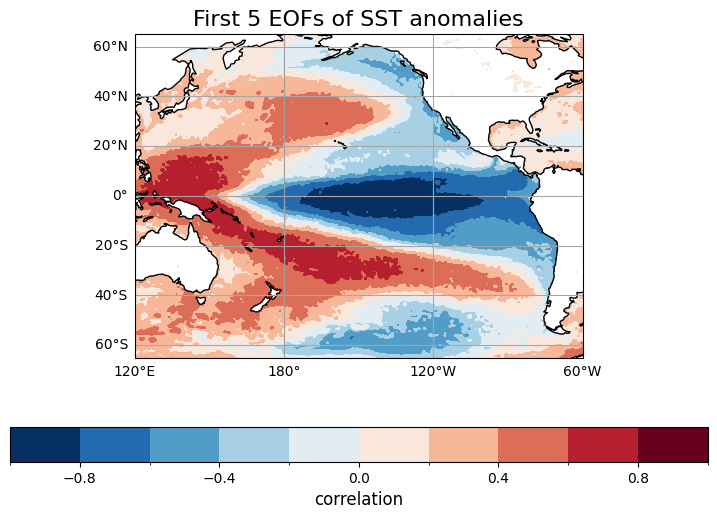

In [45]:
# Plot map of the first 5 EOFs
clevs = np.linspace(-1, 1, 11)
plt.figure(figsize=(9, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
ax.gridlines()
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation', fontsize=12)
ax.set_title('First 5 EOFs of SST anomalies', fontsize=16)



##### 4) Plot the percent of variance explained by the first 10 EOFs.


(2.3649818455456556e-15, 0.24725952744483948)

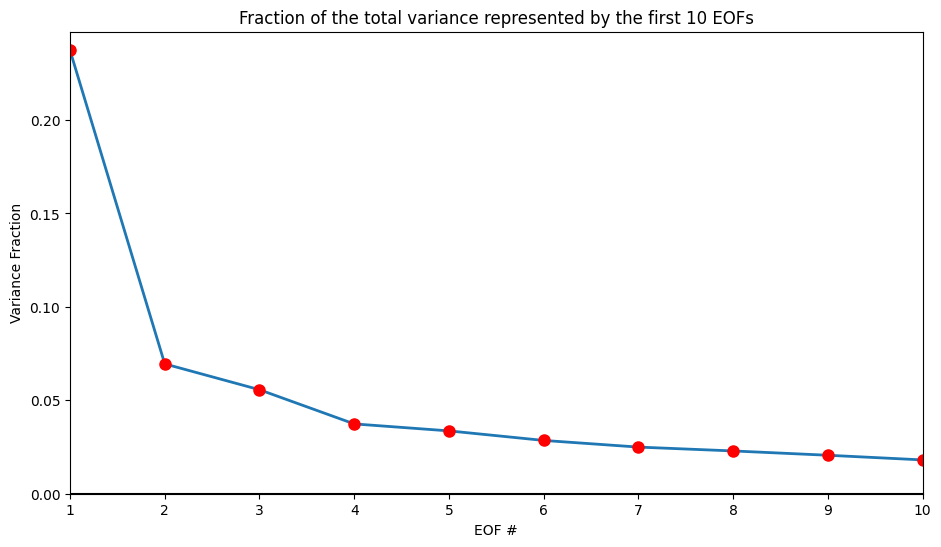

In [32]:
varfrac = solver.varianceFraction() # Compute variance fraction

# Plot the percent of variance explained by the first 10 EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by the first 10 EOFs')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

##### 5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series (which will be "retrended" and "unstandardized") and the "observed" SST time series.

In [19]:
reconstruction = solver.reconstructedField(5)
reconstruction

<xarray.DataArray 'sst' (time: 552, latitude: 521, longitude: 721)> Size: 829MB
array([[[-0.17084183, -0.184456  , -0.19771978, ...,         nan,
                 nan,         nan],
        [-0.20864014, -0.21035036, -0.21697165, ..., -0.208071  ,
         -0.206647  , -0.20735206],
        [-0.27977914, -0.26650688, -0.25305504, ..., -0.27579325,
         -0.27220002, -0.27612215],
        ...,
        [ 0.22087084,  0.23020934,  0.23952287, ...,  0.21357591,
          0.21736494,  0.21861053],
        [ 0.20980762,  0.22025795,  0.23074982, ...,  0.18009509,
          0.18674354,  0.19794194],
        [ 0.16361918,  0.17437957,  0.18523295, ...,  0.12729864,
          0.13866152,  0.1512145 ]],

       [[-0.09595469, -0.11298286, -0.1298072 , ...,         nan,
                 nan,         nan],
        [-0.15305701, -0.16519281, -0.18333341, ..., -0.14595668,
         -0.14479908, -0.1476214 ],
        [-0.27164596, -0.26545715, -0.25892887, ..., -0.23951869,
         -0.24296662, -0.2575043 ],
...
        [-0.03247203, -0.03724483, -0.04189166, ..., -0.04305882,
         -0.04007879, -0.0361489 ],
        [-0.03095439, -0.03855459, -0.04609062, ..., -0.04418467,
         -0.03895864, -0.03485234],
        [-0.00882989, -0.01533902, -0.02075353, ..., -0.01890939,
         -0.01305916, -0.01148661]],

       [[ 0.20300047,  0.21719903,  0.230772  , ...,         nan,
                 nan,         nan],
        [ 0.22864422,  0.21750577,  0.21055934, ...,  0.29547554,
          0.2812386 ,  0.2552362 ],
        [ 0.26870036,  0.24461998,  0.22050717, ...,  0.35901138,
          0.3244938 ,  0.29669482],
        ...,
        [-0.12325186, -0.12856294, -0.13379413, ..., -0.12233971,
         -0.12472195, -0.12347803],
        [-0.11434015, -0.1213543 , -0.1283452 , ..., -0.10359351,
         -0.10673942, -0.11014242],
        [-0.0722376 , -0.07910839, -0.08572225, ..., -0.0563357 ,
         -0.06162442, -0.06708763]]], shape=(552, 521, 721), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
    number     (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    expver     (time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001' '0001'
Attributes:
    long_name:  sst_reconstructed_with_5_EOFs

In [20]:
STANDARDIZED_INPUT = False 

if STANDARDIZED_INPUT:
    mean_det = sst_detrended.mean("time", skipna=True)
    std_det  = sst_detrended.std("time",  skipna=True)
    std_det  = xr.where(std_det==0, xr.zeros_like(std_det)+1.0, std_det)
    recon_unstd = reconstruction * std_det + mean_det
else:
    recon_unstd = reconstruction

In [ ]:
# Retrend
t = xr.DataArray(np.arange(sst_ds.sizes["time"]), coords={"time": sst_ds["time"]}, dims="time")
coef  = sst_ds.polyfit(dim="time", deg=1, skipna=True)
trend = xr.polyval(t, coef["polyfit_coefficients"])  
recon_retrend = recon_unstd + trend

In [ ]:
# Correlation of retrended and observed SST 
recon_retrend, sst_ds_aligned = xr.align(recon_retrend, sst_ds, join="inner")
rmap = xr.corr(recon_retrend, sst_ds_aligned, dim="time")  


/Users/Haley/atms523/ATMS-523-Module-4/xarray-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Haley/atms523/ATMS-523-Module-4/xarray-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


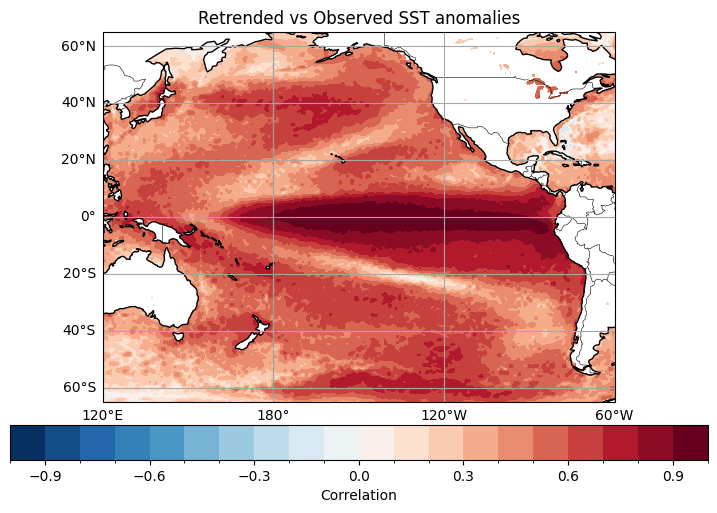

In [47]:
# Plot correlation map 
plt.figure(figsize=(9, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
levels = np.linspace(-1, 1, 21)
im = rmap.plot.contourf(
    ax=ax, levels=levels, cmap=plt.cm.RdBu_r, add_colorbar=False,
    transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
ax.gridlines()  
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
cb = plt.colorbar(im, orientation='horizontal', pad=0.05)
cb.set_label("Correlation")
ax.set_title("Retrended vs Observed SST anomalies")
plt.show()

##### 6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?

In [38]:
pc1 = solver.pcs(1, 1).squeeze("mode")  # time series of first EOF 


tcwv_std = (tcwv_detrended - tcwv_detrended.mean("time", skipna=True)) / tcwv_detrended.std("time", skipna=True) # Standardize TCWV anomalies 


pc1, tcwv_std = xr.align(pc1, tcwv_std, join="inner") # Align time of PC1 and TCWV


r_tcwv = xr.corr(pc1, tcwv_std, dim="time") # Compute correlation


/Users/Haley/atms523/ATMS-523-Module-4/xarray-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Haley/atms523/ATMS-523-Module-4/xarray-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Haley/atms523/ATMS-523-Module-4/xarray-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


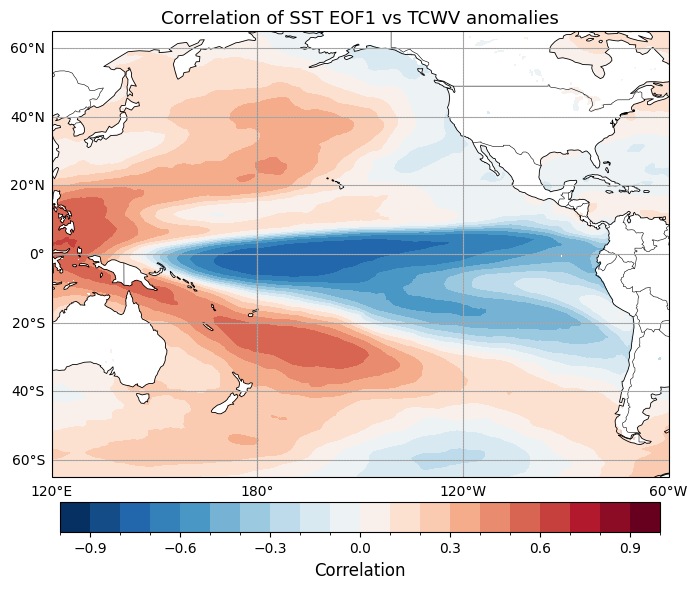

In [43]:
# Plot correlation map
clevs = np.linspace(-1, 1, 21)
proj = ccrs.PlateCarree(central_longitude=190)

plt.figure(figsize=(9,6))
ax = plt.axes(projection=proj)
im = r_tcwv.plot.contourf(
    ax=ax, levels=clevs, cmap=plt.cm.RdBu_r, add_colorbar=False,
    transform=ccrs.PlateCarree()
)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
cb = plt.colorbar(im, orientation='horizontal', pad=0.05, fraction=0.06)
cb.set_label("Correlation", fontsize=12)
ax.set_title("Correlation of SST EOF1 vs TCWV anomalies", fontsize=13)
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
ax.gridlines()  
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.tight_layout()
plt.show()